In [1]:
## import modules

import os
import numpy as np
import scipy.io as sio
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.cluster import MiniBatchKMeans, KMeans
import sklearn.metrics

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt 
import tensorflow as tf



In [2]:
window_size = 25 ## length of the sliding window to create sequences
trn_ratio = 0.60  ## first 60%-train, 20% - validation, 20% - test
val_ratio = 0.80
        

## import dataset : 4 datasets avaliable

In [3]:
dataset = sio.loadmat('./data/beedance.mat')
#dataset = sio.loadmat('./data/yahoo.mat')
#dataset = sio.loadmat('./data/hasc.mat')
#dataset = sio.loadmat('./data/fishkiller.mat')
    
Y = dataset['Y']                # Y: time series data; time length (T) x number of variables (D) => T x D
L = dataset['L']                # L: binary labels; time length (T) x 1 (labeled by 0 or 1)

T, D = Y.shape                  # T: time length; D: number of variables
    
n_trn = int(np.ceil(T * trn_ratio)) # splitting point between train set and validation set 
n_val = int(np.ceil(T * val_ratio))  # splitting point between validation set and test set

n_tst = T-window_size
print('Length of dataset:', T, 'Number of variables:', D, 'First index of validation set:', n_trn, 'First index of test set:', n_val)

#print(n_tst)

train_set_idx = range(window_size, n_trn)
val_set_idx = range(n_trn, n_val)
test_set_idx = range(n_val, n_tst)

print('number_of_training_samples:', len(train_set_idx), 'number_of_validation_samples:', len(val_set_idx), 'number_of_test_samples:', len(test_set_idx)) ## number of train samples, number of validation samples, number of test samples

Length of dataset: 1057 Number of variables: 3 First index of validation set: 635 First index of test set: 846
number_of_training_samples: 610 number_of_validation_samples: 211 number_of_test_samples: 186


In [4]:
## Function for flattening observations in a single vector

def flatten(data, idx, window_size, dim):
    return data.reshape((len(idx), window_size*D))

In [5]:
##creating present past window of observation for comparison to identify changepoint

def train_test(idx, window_size, Y, L): 
    n = len(idx)
    #g = n-1
    #print(n)
    
    A = torch.zeros((n, D))  
    #print(A.size())
    B = torch.zeros((n, 1))
    #print(B.size())
    
    X_p = torch.zeros((n, window_size, D)) ## past samples sequence set created by sliding window
    #print(X_p.size())
    X_f = torch.zeros((n, window_size, D)) ## future samples sequence set created by sliding window
    #print(X_f.size())
    
    for i in range(n):
        l = idx[i] - window_size
        #print(l)
        m = idx[i]
        #print(m)
        n = idx[i] + window_size
        #print(n)

        X_p[i, :, :] = torch.from_numpy(Y[l:m, :])
        X_f[i, :, :] = torch.from_numpy(Y[m:n, :])
            
        A[i, :] = torch.from_numpy(Y[m, :])
        
        B[i] = torch.from_numpy(L[m])
            

    #data, future_data, true_data, labels = Variable(X_p), Variable(X_f), Variable(A), Variable(B)
    X_p =  flatten(X_p, idx, window_size, D) 
    X_f =  flatten(X_f, idx, window_size, D)
    
    data, future_data, true_data, labels = Variable(X_p), Variable(X_f), Variable(A), Variable(B)
    
    return data, future_data, true_data, labels

In [6]:
train_dataset, future_train, true_train, labels_train = train_test(train_set_idx, window_size, Y, L)
valid_dataset, future_valid, true_valid, labels_valid = train_test(val_set_idx, window_size, Y, L)
test_dataset, future_test, true_test, labels_test = train_test(test_set_idx, window_size, Y, L)

print('Shape of Sequenced Samples for Training:', train_dataset.size())
print('Shape of Sequenced Samples for Validation:', valid_dataset.size())
print('Shape of Sequenced Samples for Testing:', test_dataset.size())
print('Shape of Sequenced Future Samples for Training:', future_train.size())
print('Shape of Sequenced Future Samples for Validation:', future_valid.size())
print('Shape of Sequenced Future Samples for Testing:', future_test.size())
print('Shape of Original Train Data:', true_train.size())
print('Shape of Original Validation Data:', true_valid.size())
print('Shape of Original Test Data:', true_test.size())
print('Shape of Training Labels:', labels_train.size())
print('Shape of Validation Labels:', labels_valid.size())
print('Shape of Testing Labels:', labels_test.size())

Shape of Sequenced Samples for Training: torch.Size([610, 75])
Shape of Sequenced Samples for Validation: torch.Size([211, 75])
Shape of Sequenced Samples for Testing: torch.Size([186, 75])
Shape of Sequenced Future Samples for Training: torch.Size([610, 75])
Shape of Sequenced Future Samples for Validation: torch.Size([211, 75])
Shape of Sequenced Future Samples for Testing: torch.Size([186, 75])
Shape of Original Train Data: torch.Size([610, 3])
Shape of Original Validation Data: torch.Size([211, 3])
Shape of Original Test Data: torch.Size([186, 3])
Shape of Training Labels: torch.Size([610, 1])
Shape of Validation Labels: torch.Size([211, 1])
Shape of Testing Labels: torch.Size([186, 1])


In [20]:
# hyperparameters

epochs = 1000
batch_size = 128
learning_rate = 1e-5

x_dim = 75     ## dimension of input
z_dim = 3     ## dimension of latent space

print_every=10
save_every=10
seed =100
beta = 1

torch.manual_seed(seed)
plt.ion()

In [21]:
## Neural Network 40-30-20-z

class encoder (nn.Module):
    def __init__(self, x_dim, z_dim):
        super(encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(x_dim, 40),  
            nn.ReLU(),
            nn.Linear(40, 30),     
            nn.ReLU(),
            nn.Linear(30, 20),     
            nn.ReLU(),
            nn.Linear(20, z_dim))
            
    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        return x
    
    
class decoder (nn.Module):
    def __init__(self, x_dim, z_dim):
        super(decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 30),
            nn.ReLU(),
            nn.Linear(30, 40), 
            nn.ReLU(),
            nn.Linear(40, x_dim))
        
    def forward(self, x):
        for layer in self.decoder:
            x = layer(x)
        return x
    
    
class autoencoder(nn.Module):
    def __init__(self, x_dim, z_dim):
        super(autoencoder, self). __init__()
        self.Encoder = encoder(x_dim, z_dim)
        self.Decoder = decoder(x_dim, z_dim)
        
    def forward(self, x):
        z = self.Encoder(x)
        x_hat = self.Decoder(z)
        
        return z, x_hat

## Dataloader for pyTorch

In [22]:
##Past
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last = False)

In [23]:
##Future
train_loader_future = torch.utils.data.DataLoader(future_train, batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader_future = torch.utils.data.DataLoader(future_valid, batch_size=batch_size, shuffle=False, drop_last = False)
test_loader_future = torch.utils.data.DataLoader(future_test, batch_size=batch_size, shuffle=False, drop_last = False)

In [24]:
## Labels
labels_loader_train = torch.utils.data.DataLoader(labels_train, batch_size=batch_size, shuffle=False, drop_last = False)
labels_loader_valid = torch.utils.data.DataLoader(labels_valid, batch_size=batch_size, shuffle=False, drop_last = False)
labels_loader_test= torch.utils.data.DataLoader(labels_test, batch_size=batch_size, shuffle=False, drop_last = False)

In [25]:
## RBF kernel computing module

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1) 
    
    #print('X shape', x.size())
    #print('Y shape', y.size())
    
    kernel_input = (x - y).pow(2).mean(1)/float(dim) ## Gaussian Kernel
    
    #print('KERNEL:', kernel_input.size())
    
    return torch.exp(-kernel_input)
    

## computes mmd loss between current and future sample

def _mmd_loss(X_p, X_f):        
    #X_p, X_f = self._past_future(x)
    p_kernel = compute_kernel(X_p, X_p)
    #print('P-kernel:', p_kernel)
    f_kernel = compute_kernel(X_f,X_f)
    #print('F-kernel:', f_kernel.size())
    pf_kernel = compute_kernel(X_p,X_f)
    #print('PF-kernel:', pf_kernel.size())
    mmd = p_kernel + f_kernel - 2*pf_kernel     ## size: batch size
    #print('MMD:', mmd.size())
    
    return mmd
    
    
## Validation using prediction scores with validation ground truths

def valid_epoch(epoch, labels_pred, labels):
    labels_pred = labels_pred.detach().numpy()  ## per sample mmd scores from training
    #print(labels_pred.shape)
    labels_true = labels.squeeze()             ## training labels
    #print(labels.size())
    
    fp_list, tp_list, thresholds = sklearn.metrics.roc_curve(labels_true, labels_pred)
    auc = sklearn.metrics.auc(fp_list, tp_list)
    
    return auc
    
    


In [26]:
# train 

def train(epoch):
    writer = SummaryWriter('ae_runs/train_run10')   ## use for tensorboard visualization
    
    total_loss, total_loss_p, total_loss_f, total_loss_k =0, 0, 0, 0
    total_mmd = []
    
    for batch_idx, (data, future_data) in enumerate(zip(train_loader, train_loader_future)):
        #print('data', data.size())
        
        optimizer.zero_grad()
        z_p, x_hat_p =  model(data)
        z_f, x_hat_f = model(future_data)
        
        #print('encoded', z.size())
        #print('decoded', x_hat.size())
        
        loss_p = criterion(data, x_hat_p)
        loss_f = criterion(future_data, x_hat_f)
    
        mmd = _mmd_loss(z_p, z_f)
        #print('MMD:', mmd)
        loss_m = mmd.mean()
        
        loss = loss_p + loss_f + beta*loss_m
        
        loss.backward()
        optimizer.step()
        
        total_loss_p +=loss_p.data
        total_loss_f +=loss_f.data
        total_loss +=loss.data
        
        #print('batch mmd', mmd.size())
        total_mmd.append(mmd)
        #print('batch_id', batch_idx)
    
    mmd_score = torch.cat(total_mmd, dim=0)
    #print('all_mmd', mmd_score.size())
    labels_pred = mmd_score
    
    auc = valid_epoch(epoch, labels_pred, labels_train)
    mmd_mean = mmd_score.mean().detach().numpy()
    #print('Train mmd:', mmd_mean)
    
    if epoch % print_every == 1:
        print("Train Epoch: {} Reconstruction Loss (P) is {:.5f} \t Reconstruction Loss (F) is {:.5f} \t Total Loss: {:0.5f} \t MMD: {:0.5f} \t AUC: {:.5f}".format(epoch +1, total_loss_p/len(train_loader.dataset), total_loss_f/len(train_loader.dataset), total_loss/len(train_loader.dataset), mmd_mean, auc))
    
    ## for tensorboard
    writer.add_scalar('Rec Loss (Train)', total_loss, epoch)
    writer.add_scalar('MMD Score (Train)', mmd_mean, epoch)
    writer.add_scalar('Total Loss (Train)', total_loss+mmd_mean , epoch)
    writer.add_scalar('AUC Score (Train)', auc, epoch)
    writer.close()
    
    return auc

In [27]:
#validate
def valid(epoch):
    writer = SummaryWriter('ae_runs/valid_run10')
    
    total_loss, total_loss_p, total_loss_f, total_loss_k =0, 0, 0, 0
    total_mmd = []
    
    for batch_idx, (data, future_valid) in enumerate(zip(valid_loader, valid_loader_future)):
        
        z_p, x_hat_p =  model(data)
        z_f, x_hat_f = model(future_valid)
        
        loss_p = criterion(data, x_hat_p)
        loss_f = criterion(future_valid, x_hat_f)
        mmd = _mmd_loss(z_p, z_f)
        loss_m = mmd.mean()
        
        loss = loss_p + loss_f + beta*loss_m
        
        total_loss_p +=loss_p.data
        total_loss_f +=loss_f.data
        total_loss += loss.data
          
        #print(mmd.size())
        total_mmd.append(mmd)
    
    mmd_score = torch.cat(total_mmd, dim=0)
    #print(mmd_score.size())
    labels_pred = mmd_score
    
    auc = valid_epoch(epoch, labels_pred, labels_valid)
    mmd_mean = mmd_score.mean().detach().numpy()
    #print('Test mmd:', mmd_mean)
    
    if epoch % print_every == 1:
        print("Valid Epoch: {} Reconstruction Loss (P) is {:.5f} \t Reconstruction Loss (F) is {:.5f} \t  Total Loss: {:0.5f} \t MMD: {:0.5f} \t AUC: {:.5f}".format(epoch +1, total_loss_p/len(valid_loader.dataset), total_loss_f/len(valid_loader.dataset), total_loss/len(valid_loader.dataset), mmd_mean, auc))
    
    ## for tensorboard
    writer.add_scalar('Rec Loss (Test)', total_loss, epoch)
    writer.add_scalar('MMD Score (Test)', mmd_mean, epoch)
    writer.add_scalar('Total Loss (Test)', total_loss+mmd_mean , epoch)
    writer.add_scalar('AUC Score (Test)', auc, epoch)
    
    writer.close()
    
    return auc, mmd_mean, total_loss

In [28]:
# test 

def test(path, epoch):
    writer = SummaryWriter('ae_runs/test_run10')
    
    total_loss, total_loss_p, total_loss_f, total_loss_k  =0, 0, 0, 0
    total_mmd = []
    Z_p = []
    Z_f = []
    for batch_idx, (data, future_test) in enumerate(zip(test_loader, test_loader_future)):
        
        model = load_checkpoint(path)
        
        z_p, x_hat_p =  model(data)
        z_f, x_hat_f = model(future_test)
        
        loss_p = criterion(data, x_hat_p)
        loss_f = criterion(future_test, x_hat_f)
        mmd = _mmd_loss(z_p, z_f)
        loss_m = mmd.mean()
        
        loss = loss_p + loss_f + beta*loss_m
        
        total_loss_p +=loss_p.data
        total_loss_f +=loss_f.data
        #total_loss_k += loss_k.data
        total_loss +=loss.data
          
        #print(mmd.size())
        total_mmd.append(mmd)
        Z_p.append(z_p)
        Z_f.append(z_f)
    
    mmd_score = torch.cat(total_mmd, dim=0)
    Z_p_total = torch.cat(Z_p, dim=0)
    Z_f_total = torch.cat(Z_f, dim=0)
    #print(mmd_score.size())
    
    labels_pred = mmd_score
    
    auc = valid_epoch(epoch, labels_pred, labels_test)
    mmd_mean = mmd_score.mean().detach().numpy()
    #print('Test mmd:', mmd_mean)
    
    if epoch % print_every == 1:
        print("Test Loss: {:0.5f} \t MMD: {:0.5f} \t AUC: {:.5f}".format(total_loss/len(test_loader.dataset), mmd_mean, auc))
    
    writer.add_scalar('Rec Loss (Test)', total_loss, epoch)
    writer.add_scalar('MMD Score (Test)', mmd_mean, epoch)
    writer.add_scalar('Total Loss (Test)', total_loss+mmd_mean , epoch)
    writer.add_scalar('AUC Score (Test)', auc, epoch)
    
    writer.close()
    
    return auc, mmd_score

In [29]:
## model
model = autoencoder(x_dim, z_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [30]:
# load saved model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

In [31]:
# stopping criteria

def dae_cpd(epochs):
    best_val_auc = -1
    best_mmd = -1
    best_epoch = -1

    train_AUC = []
    val_AUC = []
    test_AUC = []
    
    for epoch in range(epochs):
    
        #training + validation
        train_auc = train(epoch)
        val_auc, mmd, loss = valid(epoch)
        #test_auc, mmd_score, mmd, Z_p, Z_f, loss = test(epoch)
    
        if val_auc > best_val_auc:
        #if mmd > best_mmd:
            best_val_auc = val_auc
            best_epoch = epoch
            best_mmd = mmd

            #print('Saved model to '+ fn)
        
    print("Best Epoch: {} \t Best MMD: {:.5f} \t Best AUC: {:.5f} ".format(best_epoch, best_mmd, best_val_auc))
    
    #saving model
    fn = 'ae_saves/ae_state_dict_'+ str(best_epoch)+'.pth'
    checkpoint = { 'model': autoencoder(x_dim, z_dim), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, fn)
    
    auc, mmd_score = test(fn, 1)
    
    return auc, mmd_score
    
        

In [32]:
# run method

auc, mmd = dae_cpd(epochs)

Train Epoch: 2 Reconstruction Loss (P) is 0.00202 	 Reconstruction Loss (F) is 0.00197 	 Total Loss: 0.00399 	 MMD: 0.00001 	 AUC: 0.59182
Valid Epoch: 2 Reconstruction Loss (P) is 0.00254 	 Reconstruction Loss (F) is 0.00266 	  Total Loss: 0.00519 	 MMD: 0.00001 	 AUC: 0.41848
Train Epoch: 12 Reconstruction Loss (P) is 0.00201 	 Reconstruction Loss (F) is 0.00196 	 Total Loss: 0.00397 	 MMD: 0.00001 	 AUC: 0.62491
Valid Epoch: 12 Reconstruction Loss (P) is 0.00252 	 Reconstruction Loss (F) is 0.00264 	  Total Loss: 0.00516 	 MMD: 0.00001 	 AUC: 0.43901
Train Epoch: 22 Reconstruction Loss (P) is 0.00200 	 Reconstruction Loss (F) is 0.00195 	 Total Loss: 0.00395 	 MMD: 0.00001 	 AUC: 0.66209
Valid Epoch: 22 Reconstruction Loss (P) is 0.00251 	 Reconstruction Loss (F) is 0.00263 	  Total Loss: 0.00513 	 MMD: 0.00001 	 AUC: 0.49034
Train Epoch: 32 Reconstruction Loss (P) is 0.00199 	 Reconstruction Loss (F) is 0.00194 	 Total Loss: 0.00392 	 MMD: 0.00001 	 AUC: 0.67871
Valid Epoch: 32 Rec

Train Epoch: 302 Reconstruction Loss (P) is 0.00157 	 Reconstruction Loss (F) is 0.00153 	 Total Loss: 0.00310 	 MMD: 0.00005 	 AUC: 0.61231
Valid Epoch: 302 Reconstruction Loss (P) is 0.00197 	 Reconstruction Loss (F) is 0.00207 	  Total Loss: 0.00404 	 MMD: 0.00005 	 AUC: 0.62440
Train Epoch: 312 Reconstruction Loss (P) is 0.00155 	 Reconstruction Loss (F) is 0.00151 	 Total Loss: 0.00306 	 MMD: 0.00006 	 AUC: 0.61254
Valid Epoch: 312 Reconstruction Loss (P) is 0.00194 	 Reconstruction Loss (F) is 0.00204 	  Total Loss: 0.00398 	 MMD: 0.00006 	 AUC: 0.64614
Train Epoch: 322 Reconstruction Loss (P) is 0.00153 	 Reconstruction Loss (F) is 0.00148 	 Total Loss: 0.00301 	 MMD: 0.00008 	 AUC: 0.62202
Valid Epoch: 322 Reconstruction Loss (P) is 0.00191 	 Reconstruction Loss (F) is 0.00201 	  Total Loss: 0.00392 	 MMD: 0.00008 	 AUC: 0.64010
Train Epoch: 332 Reconstruction Loss (P) is 0.00150 	 Reconstruction Loss (F) is 0.00146 	 Total Loss: 0.00296 	 MMD: 0.00010 	 AUC: 0.62711
Valid Epoc

Train Epoch: 592 Reconstruction Loss (P) is 0.00073 	 Reconstruction Loss (F) is 0.00071 	 Total Loss: 0.00146 	 MMD: 0.00308 	 AUC: 0.64547
Valid Epoch: 592 Reconstruction Loss (P) is 0.00087 	 Reconstruction Loss (F) is 0.00090 	  Total Loss: 0.00180 	 MMD: 0.00292 	 AUC: 0.67512
Train Epoch: 602 Reconstruction Loss (P) is 0.00071 	 Reconstruction Loss (F) is 0.00068 	 Total Loss: 0.00142 	 MMD: 0.00331 	 AUC: 0.64517
Valid Epoch: 602 Reconstruction Loss (P) is 0.00084 	 Reconstruction Loss (F) is 0.00087 	  Total Loss: 0.00174 	 MMD: 0.00314 	 AUC: 0.67633
Train Epoch: 612 Reconstruction Loss (P) is 0.00068 	 Reconstruction Loss (F) is 0.00066 	 Total Loss: 0.00137 	 MMD: 0.00353 	 AUC: 0.64532
Valid Epoch: 612 Reconstruction Loss (P) is 0.00081 	 Reconstruction Loss (F) is 0.00084 	  Total Loss: 0.00168 	 MMD: 0.00336 	 AUC: 0.67391
Train Epoch: 622 Reconstruction Loss (P) is 0.00066 	 Reconstruction Loss (F) is 0.00064 	 Total Loss: 0.00133 	 MMD: 0.00373 	 AUC: 0.64418
Valid Epoc

Train Epoch: 882 Reconstruction Loss (P) is 0.00038 	 Reconstruction Loss (F) is 0.00037 	 Total Loss: 0.00079 	 MMD: 0.00442 	 AUC: 0.65488
Valid Epoch: 882 Reconstruction Loss (P) is 0.00044 	 Reconstruction Loss (F) is 0.00043 	  Total Loss: 0.00091 	 MMD: 0.00441 	 AUC: 0.68841
Train Epoch: 892 Reconstruction Loss (P) is 0.00038 	 Reconstruction Loss (F) is 0.00037 	 Total Loss: 0.00078 	 MMD: 0.00439 	 AUC: 0.65412
Valid Epoch: 892 Reconstruction Loss (P) is 0.00043 	 Reconstruction Loss (F) is 0.00042 	  Total Loss: 0.00089 	 MMD: 0.00439 	 AUC: 0.68841
Train Epoch: 902 Reconstruction Loss (P) is 0.00037 	 Reconstruction Loss (F) is 0.00036 	 Total Loss: 0.00077 	 MMD: 0.00436 	 AUC: 0.65473
Valid Epoch: 902 Reconstruction Loss (P) is 0.00042 	 Reconstruction Loss (F) is 0.00042 	  Total Loss: 0.00088 	 MMD: 0.00437 	 AUC: 0.68961
Train Epoch: 912 Reconstruction Loss (P) is 0.00037 	 Reconstruction Loss (F) is 0.00036 	 Total Loss: 0.00076 	 MMD: 0.00432 	 AUC: 0.65427
Valid Epoc

## Visualization

In [33]:
print('Accuracy: {:.5f}', auc)
#print('MMD scores:', mmd.size())

Accuracy: {:.5f} 0.7445054945054945


In [34]:
marker = np.where(labels_test ==1)
#print(len(marker[0]))

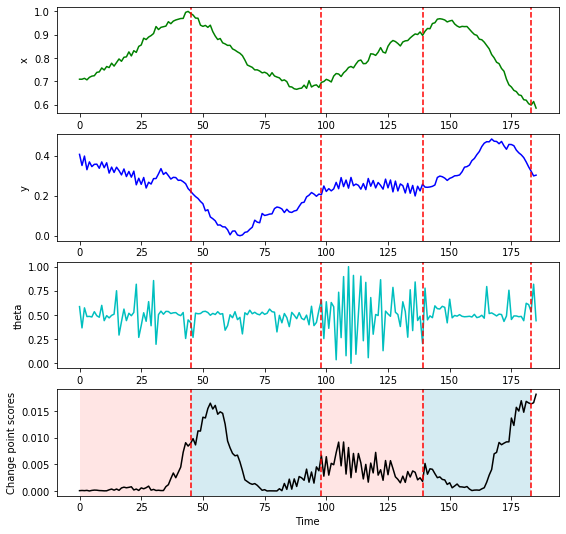

In [36]:
##plotting MMD scores per time points for test set - HASC and beedance 
time = range (846, 1032)  ##beedance

fig = plt.figure(figsize = (9, 9))

ax1 = fig.add_subplot(411)
ax1.plot(true_test[:, 0], color = 'g')
for xc in marker[0]:
    ax1.axvline(x=xc,  color = 'r', linestyle = '--')
ax1.set_ylabel('x')

ax2 = fig.add_subplot(412)
ax2.plot(true_test[:, 1], color = 'b')
for xc in marker[0]:
    ax2.axvline(x=xc,  color = 'r', linestyle = '--')
ax2.set_ylabel('y')

ax3 =fig.add_subplot(413)
ax3.plot(true_test[:, 2], color = 'c')
for xc in marker[0]:
    ax3.axvline(x=xc,  color = 'r', linestyle = '--')
ax3.set_ylabel('theta')

ax4 = fig.add_subplot(414)
ax4.plot(mmd, '-', color = 'k')
for xc in marker[0]:
    ax4.axvline(x=xc,  color = 'r', linestyle = '--')
ax4.set_ylabel('Change point scores')

plt.axvspan(0, 45, facecolor='#ffcccb', alpha=0.5)
plt.axvspan(45, 98, facecolor='#add8e6', alpha=0.5)
plt.axvspan(98, 139, facecolor='#ffcccb', alpha=0.5)
plt.axvspan(139, 183, facecolor='#add8e6', alpha=0.5)

plt.xlabel('Time')

plt.savefig('./figures/Predicted change point scores_beedance.eps')
plt.show()

## Fishkiller

In [27]:
## for one-dimension data - fishkiller 
##plotting MMD scores per time points for test set

def fishkiller():

    time = range (36140, 45170) ##fishkiller

    fig = plt.figure(figsize = (15, 9))

    ax1 = fig.add_subplot(211)
    ax1.plot(true_test[:, 0], color = 'g')
    for xc in marker[0]:
        ax1.axvline(x=xc,  color = 'r', linestyle = '--')
        ax1.set_ylabel('x')


    ax4 = fig.add_subplot(212)
    ax4.plot(mmd[0:6000], '-', color = 'b')
    
    ax4.set_ylabel('Change point scores')
    
    #plt.axvspan(0, 45, facecolor='#ffcccb', alpha=0.5)
    #plt.axvspan(45, 98, facecolor='#add8e6', alpha=0.5)
    #plt.axvspan(98, 139, facecolor='#ffcccb', alpha=0.5)
    #plt.axvspan(139, 183, facecolor='#add8e6', alpha=0.5)

    plt.xlabel('Time')

    plt.savefig('./figures/Predicted change point scores_fishkiller.eps')
    plt.show()
    
#fishkiller()

## HASC

In [29]:
##hasc

def hasc():
    fig = plt.figure(figsize = (9, 9))

    ax1 = fig.add_subplot(411)
    ax1.plot(true_test[:, 0], color = 'g')
    for xc in marker[0]:
        ax1.axvline(x=xc,  color = 'r', linestyle = '--')
        ax1.set_ylabel('x')

    ax2 = fig.add_subplot(412)
    ax2.plot(true_test[:, 1], color = 'b')
    for xc in marker[0]:
        ax2.axvline(x=xc,  color = 'r', linestyle = '--')
        ax2.set_ylabel('y')

    ax3 =fig.add_subplot(413)
    ax3.plot(true_test[:, 2], color = 'c')
    for xc in marker[0]:
        ax3.axvline(x=xc,  color = 'r', linestyle = '--')
        ax3.set_ylabel('z')

    ax4 = fig.add_subplot(414)
    ax4.plot(mmd, '-', color = 'k')
    for xc in marker[0]:
        ax4.axvline(x=xc,  color = 'r', linestyle = '--')
        ax4.set_ylabel('Change point scores')

    plt.axvspan(0, 1893, facecolor='#ffcccb', alpha=0.5)
    plt.axvspan(1893, 2048, facecolor='#add8e6', alpha=0.5)
    plt.axvspan(2048, 2178 , facecolor='#ffcccb', alpha=0.5)
    plt.axvspan(2178, 2514 , facecolor='#add8e6', alpha=0.5)
    plt.axvspan(2514, 2746, facecolor='#ffcccb', alpha=0.5)
    plt.axvspan(2746, 3813, facecolor='#add8e6', alpha=0.5)
    plt.axvspan(3813, 4010 , facecolor='#ffcccb', alpha=0.5)
    plt.axvspan(4010, 5874 , facecolor='#add8e6', alpha=0.5)
    plt.axvspan(5874, 5992 , facecolor='#ffcccb', alpha=0.5)
    plt.axvspan(5992, 6268 , facecolor='#add8e6', alpha=0.5)
    plt.axvspan(6268, 6925, facecolor='#ffcccb', alpha=0.5)
    plt.axvspan(6925, 7854 , facecolor='#add8e6', alpha=0.5)


    plt.xlabel('Time')

    plt.savefig('./figures/Predicted change point scores_hasc.eps')
    plt.show()
    
#hasc()

## Tensorboard loss visualization

In [30]:
#!tensorboard --logdir ae_runs/train_run10

In [31]:
#!tensorboard --logdir ae_runs/valid_run10  

In [32]:
#!tensorboard --logdir ae_runs/valid_run10